In [2]:
library(reshape2)
library(dplyr)
library(ggplot2)
library(scales)
library(grid)
library(tidyr)


Attaching package: ‘dplyr’

The following objects are masked from ‘package:stats’:

    filter, lag

The following objects are masked from ‘package:base’:

    intersect, setdiff, setequal, union


Attaching package: ‘tidyr’

The following object is masked from ‘package:reshape2’:

    smiths



Joining, by = "Well"
Warning message:
“Removed 561 rows containing missing values (geom_path).”

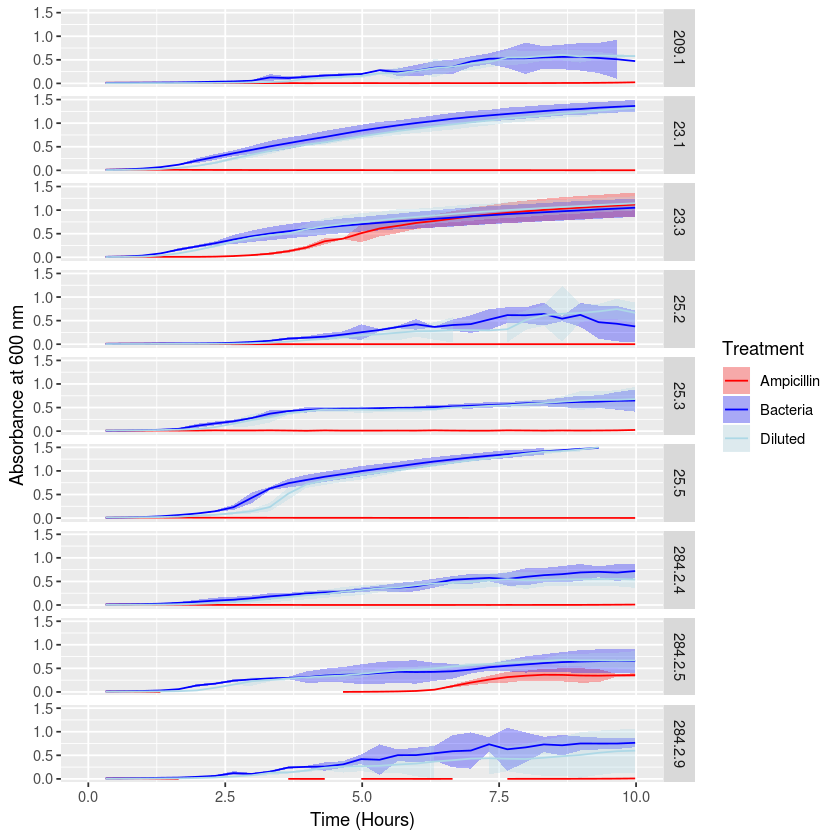

In [3]:
# Read in the raw data and the platemap. You may need to first change your
# working directory with the setwd command.
rawdata <- read.csv("OD.csv")
platemap <- read.csv("Platemap.csv")

# Reshape the data. Instead of rows containing the Time, Temperature,
# and readings for each Well, rows will contain the Time, Temperature, a
# Well ID, and the reading at that Well.
reshaped <- melt(rawdata, id=c("Time", "Temperature"), variable.name="Well", 
                 value.name="OD600")

# Add information about the experiment from the plate map. For each Well
# defined in both the reshaped data and the platemap, each resulting row
# will contain the absorbance measurement as well as the additional columns
# and values from the platemap.
X<-sort(union(reshaped$Well, platemap$Well))
reshaped<-mutate(reshaped, Well=factor(Well, levels=X))
platemap<-mutate(platemap, Well=factor(Well, levels=X))
annotated <- inner_join(reshaped, platemap)

# Save the annotated data as a CSV for storing, sharing, etc.
#write.csv(annotated, "data-annotated.csv")

conf_int95 <- function(data) {
    n <- length(data)
    error <- qt(0.975, df=n-1) * sd(data)/sqrt(n)
    return(error)
}

# Group the data by the different experimental variables and calculate the
# sample size, average OD600, and 95% confidence limits around the mean
# among the replicates. Also remove all records where the Treatment is NA.
stats <- annotated %>%
              group_by(Strain,Treatment, Time) %>%
              summarise(N=length(OD600),
                        Average=mean(OD600),
                        CI95=conf_int95(OD600)) %>%
              filter(!is.na(Treatment))

#claibrating for the Blank
stats1<-stats[stats$Treatment!="Blank",]
stats2<-stats[stats$Treatment=="Blank",]
x<-cbind(stats1$Strain,stats1$Treatment,stats1$Time,stats1$N, (stats1$Average-stats2$Average),stats1$CI95)
stats1$Average = stats1$Average-stats2$Average
stats<-stats1

#calibrating time
x<-as.POSIXlt(stats$Time, format = "%H:%M:%S")
stats$Time<- x$hour + x$min/60

# Plot the average OD600 over time for each Treatment in each Strain
x<-ggplot(data=stats, aes(x=Time, y=Average, color=Treatment)) +
    geom_ribbon(aes(ymin=Average-CI95, ymax=Average+CI95, fill=Treatment),
    color=NA, alpha=0.3) + 
    geom_line() +
    facet_grid(Strain ~ .) +
    labs(x="Time (Hours)", y="Absorbance at 600 nm")+
    ylim(0,1.5) + scale_x_continuous(limits=c(0,10)) + 
    scale_fill_manual(values=c('red', 'blue','lightblue')) +
    scale_color_manual(values= c('red', 'blue','lightblue'))
x
###########################
#calibrate pannel size

#p_fixed <- set_panel_size(x,
 #                      width  = unit(10, "cm"),
   #                  height = unit(4, "in"))
#grid.newpage()
#grid.draw(p_fixed)